# RAMP on predicting cyclist traffic in Paris

Authors: *Roman Yurchak (Symerio)*; also partially inspired by the air_passengers starting kit.


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files,
 - [train.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/train.parquet)
 - [test.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/test.parquet)

and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [3]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns,

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

and in particular the number of unique entries in each column,

In [5]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations,

In [6]:
data.groupby(["site_name", "counter_name"])["bike_count"].sum().sort_values(
    ascending=False
).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [8]:
pip install folium

                                              0.0/100.3 kB ? eta -:--:--
     -------------------------------------- 100.3/100.3 kB 5.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this RAMP problem we consider only the 30 most frequented counting sites, to limit data size.


Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points,

<Axes: xlabel='date'>

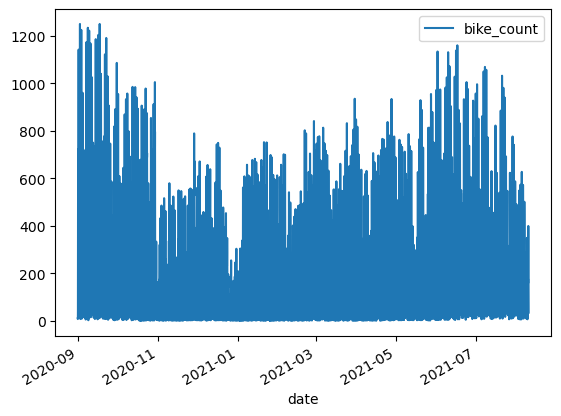

In [10]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture,

<Axes: xlabel='date'>

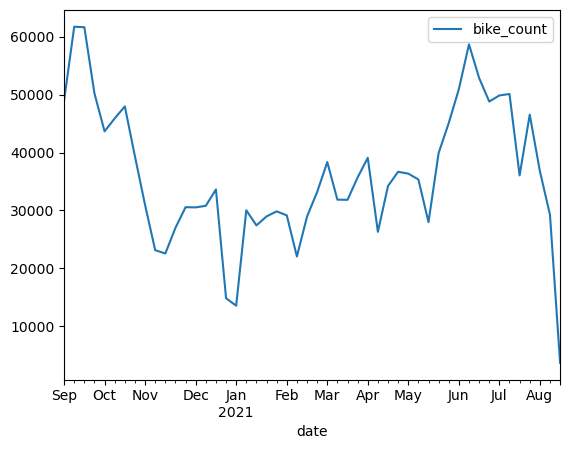

In [11]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

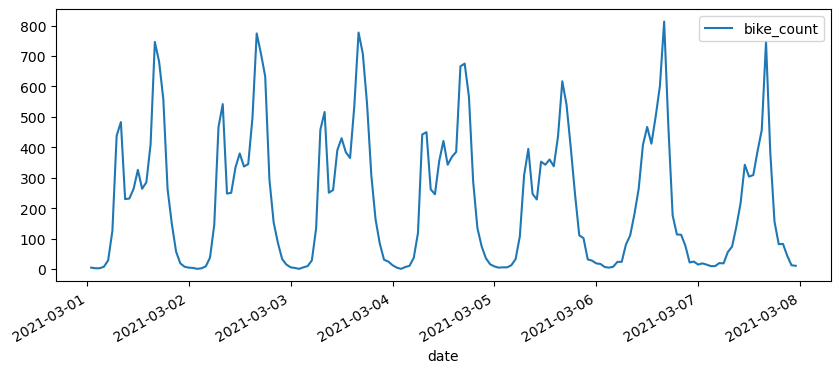

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

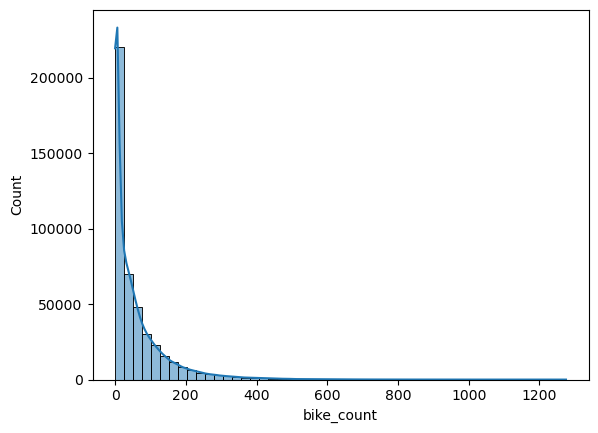

In [13]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

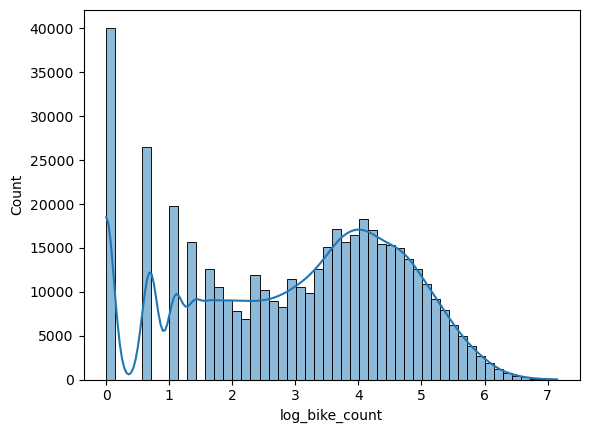

In [14]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field, 

In [15]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [16]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[ns]

In [17]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

In [18]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [19]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

c:\Users\benja\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `problem.py` of the starting kit to load the public train and test data:

In [20]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [23]:
X_train.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233


and

In [24]:
y_train

array([1.60943791, 1.38629436, 0.        , ..., 2.48490665, 1.60943791,
       1.38629436])

Where `y` contains the `log_bike_count` variable. 

The test set is in the future as compared to the train set,

In [25]:
print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=455163,  2020-09-01 01:00:00 to 2021-08-09 23:00:00
Test: n_samples=41608,  2021-08-10 01:00:00 to 2021-09-09 23:00:00


In [26]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [28]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.80
Test set, RMSE=0.73


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [29]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, np.full(y_test.shape, y_test.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.68
Test set, RMSE=1.44


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [30]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

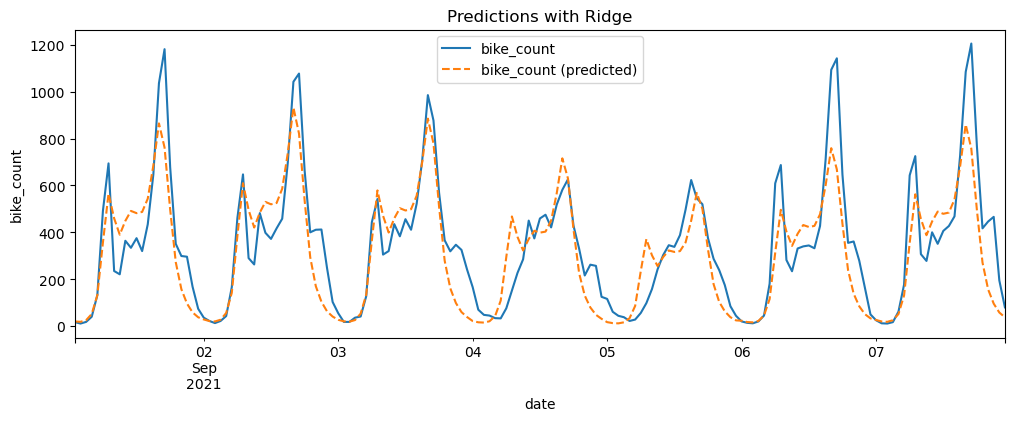

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

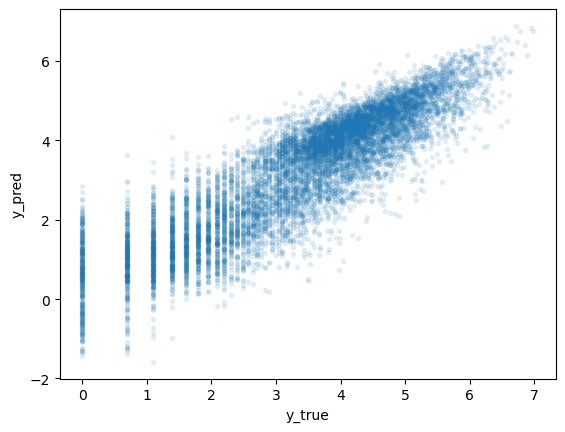

In [32]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [33]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96311224 -0.869636   -0.85359085 -0.87008334 -1.06082477 -0.97295432]
RMSE (all folds): 0.932 ± 0.0743


## Essai Régression Linéaire

In [34]:
from sklearn.linear_model import LinearRegression

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = LinearRegression()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('linearregression', LinearRegression())])

In [35]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.80
Test set, RMSE=0.73


## RandomForestRegressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = RandomForestRegressor(n_estimators = 100, n_jobs=-1, max_depth=10)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_jobs=-1))])

In [37]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=1.04
Test set, RMSE=0.97


## Essai SVR

from sklearn.svm import SVR

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = SVR()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

## Essai GradientBoostingRegressor

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = GradientBoostingRegressor(n_estimators = 100, max_depth = 5, learning_rate = 0.05)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5))])

In [39]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.91
Test set, RMSE=0.79


## Essai XGBoost 

In [40]:
pip install xgboost

                                              0.0/99.8 MB ? eta -:--:--
                                              0.2/99.8 MB 5.0 MB/s eta 0:00:20
                                              0.5/99.8 MB 6.6 MB/s eta 0:00:16
                                              0.8/99.8 MB 6.7 MB/s eta 0:00:15
                                              1.2/99.8 MB 6.4 MB/s eta 0:00:16
                                              1.5/99.8 MB 6.7 MB/s eta 0:00:15
                                              1.8/99.8 MB 6.8 MB/s eta 0:00:15
                                              2.2/99.8 MB 6.5 MB/s eta 0:00:15
                                              2.4/99.8 MB 6.8 MB/s eta 0:00:15
     -                                        2.8/99.8 MB 6.5 MB/s eta 0:00:15
     -                                        3.1/99.8 MB 6.8 MB/s eta 0:00:15
     -                                        3.4/99.8 MB 6.8 MB/s eta 0:00:15
     -                                        3.7/99.8 MB 6

In [41]:
from xgboost import XGBRegressor

In [42]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = XGBRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('xgbregressor',
                 XGBR...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [43]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.52
Test set, RMSE=0.53


## Essai CatBoost

In [44]:
pip install catboost

                                              0.0/101.0 MB ? eta -:--:--
                                              0.2/101.0 MB 5.9 MB/s eta 0:00:17
                                              0.5/101.0 MB 6.3 MB/s eta 0:00:16
                                              0.8/101.0 MB 6.6 MB/s eta 0:00:16
                                              1.1/101.0 MB 6.6 MB/s eta 0:00:16
                                              1.5/101.0 MB 6.7 MB/s eta 0:00:15
                                              1.8/101.0 MB 6.8 MB/s eta 0:00:15
                                              2.1/101.0 MB 6.7 MB/s eta 0:00:15
                                              2.4/101.0 MB 6.7 MB/s eta 0:00:15
     -                                        2.7/101.0 MB 6.7 MB/s eta 0:00:15
     -                                        3.1/101.0 MB 6.7 MB/s eta 0:00:15
     -                                        3.4/101.0 MB 6.8 MB/s eta 0:00:15
     -                                        3

In [45]:
from catboost import CatBoostRegressor

In [46]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = CatBoostRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Learning rate set to 0.107689
0:	learn: 1.6001757	total: 150ms	remaining: 2m 29s
1:	learn: 1.5371004	total: 162ms	remaining: 1m 20s
2:	learn: 1.4839691	total: 172ms	remaining: 57.3s
3:	learn: 1.4390804	total: 184ms	remaining: 45.8s
4:	learn: 1.3998436	total: 196ms	remaining: 38.9s
5:	learn: 1.3676495	total: 208ms	remaining: 34.4s
6:	learn: 1.3402819	total: 220ms	remaining: 31.2s
7:	learn: 1.3116148	total: 231ms	remaining: 28.6s
8:	learn: 1.2905022	total: 242ms	remaining: 26.7s
9:	learn: 1.2647708	total: 253ms	remaining: 25.1s
10:	learn: 1.2421408	total: 265ms	remaining: 23.8s
11:	learn: 1.2235610	total: 275ms	remaining: 22.7s
12:	learn: 1.2070045	total: 286ms	remaining: 21.7s
13:	learn: 1.1905718	total: 298ms	remaining: 21s
14:	learn: 1.1747400	total: 309ms	remaining: 20.3s
15:	learn: 1.1587924	total: 320ms	remaining: 19.7s
16:	learn: 1.1454541	total: 331ms	remaining: 19.1s
17:	learn: 1.1329833	total: 342ms	remaining: 18.6s
18:	learn: 1.1212561	total: 352ms	remaining: 18.2s
19:	learn: 

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000001891DFB4950>)])

In [47]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.48
Test set, RMSE=0.47


## Essai Light GBM

In [48]:
pip install lightgbm

                                              0.0/1.3 MB ? eta -:--:--
     -------                                  0.3/1.3 MB 7.9 MB/s eta 0:00:01
     ------------------                       0.6/1.3 MB 7.5 MB/s eta 0:00:01
     ----------------------------             0.9/1.3 MB 7.3 MB/s eta 0:00:01
     -------------------------------------    1.2/1.3 MB 7.1 MB/s eta 0:00:01
     ---------------------------------------- 1.3/1.3 MB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [49]:
from lightgbm import LGBMRegressor

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = LGBMRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 455163, number of used features: 162
[LightGBM] [Info] Start training from score 3.048589


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('lgbmregressor', LGBMRegressor())])

In [50]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.58
Test set, RMSE=0.61


## Essai AdaBoostRegressor

In [51]:
from sklearn.ensemble import AdaBoostRegressor

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = AdaBoostRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('adaboostregressor', AdaBoostRegressor())])

In [52]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=1.52
Test set, RMSE=1.34


## Choix de CatBoost et XGBoost

In [53]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = CatBoostRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Learning rate set to 0.107689
0:	learn: 1.6001757	total: 13.6ms	remaining: 13.6s
1:	learn: 1.5371004	total: 25.4ms	remaining: 12.7s
2:	learn: 1.4839691	total: 36.6ms	remaining: 12.2s
3:	learn: 1.4390804	total: 47.9ms	remaining: 11.9s
4:	learn: 1.3998436	total: 59.7ms	remaining: 11.9s
5:	learn: 1.3676495	total: 71.4ms	remaining: 11.8s
6:	learn: 1.3402819	total: 82.2ms	remaining: 11.7s
7:	learn: 1.3116148	total: 93.3ms	remaining: 11.6s
8:	learn: 1.2905022	total: 104ms	remaining: 11.5s
9:	learn: 1.2647708	total: 116ms	remaining: 11.5s
10:	learn: 1.2421408	total: 127ms	remaining: 11.4s
11:	learn: 1.2235610	total: 138ms	remaining: 11.3s
12:	learn: 1.2070045	total: 148ms	remaining: 11.3s
13:	learn: 1.1905718	total: 160ms	remaining: 11.3s
14:	learn: 1.1747400	total: 171ms	remaining: 11.2s
15:	learn: 1.1587924	total: 183ms	remaining: 11.2s
16:	learn: 1.1454541	total: 194ms	remaining: 11.2s
17:	learn: 1.1329833	total: 206ms	remaining: 11.2s
18:	learn: 1.1212561	total: 221ms	remaining: 11.4s
19:

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001891F148360>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000001892E826FD0>)])

In [54]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.48
Test set, RMSE=0.47


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [ ]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [55]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

Learning rate set to 0.079186
0:	learn: 1.5440725	total: 4.61ms	remaining: 4.61s
1:	learn: 1.4916664	total: 8.77ms	remaining: 4.38s
2:	learn: 1.4451647	total: 12.5ms	remaining: 4.16s
3:	learn: 1.4032213	total: 16ms	remaining: 3.99s
4:	learn: 1.3651348	total: 19.3ms	remaining: 3.84s
5:	learn: 1.3319628	total: 22.6ms	remaining: 3.74s
6:	learn: 1.3020603	total: 26ms	remaining: 3.69s
7:	learn: 1.2755205	total: 28.8ms	remaining: 3.57s
8:	learn: 1.2521331	total: 32.1ms	remaining: 3.53s
9:	learn: 1.2310852	total: 34.9ms	remaining: 3.45s
10:	learn: 1.2066406	total: 38.6ms	remaining: 3.47s
11:	learn: 1.1885753	total: 41.6ms	remaining: 3.42s
12:	learn: 1.1712669	total: 45ms	remaining: 3.41s
13:	learn: 1.1509147	total: 48.2ms	remaining: 3.39s
14:	learn: 1.1325107	total: 51.4ms	remaining: 3.38s
15:	learn: 1.1179249	total: 54.3ms	remaining: 3.34s
16:	learn: 1.1016128	total: 57.3ms	remaining: 3.31s
17:	learn: 1.0885221	total: 60.2ms	remaining: 3.28s
18:	learn: 1.0742393	total: 63.3ms	remaining: 3.27

KeyboardInterrupt: 

## Crossvalidation Version CatBoost

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = CatBoostRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)

# Définir la grille des hyperparamètres que vous souhaitez rechercher
param_grid = {
    'catboostregressor__iterations': [400, 600, 800, 1000, 1200],
    'catboostregressor__learning_rate': [0.2, 0.4, 0.6],
    # Ajoutez d'autres hyperparamètres et valeurs spécifiques à CatBoostRegressor
}

# Créer l'objet GridSearchCV avec votre pipeline et la grille des hyperparamètres
grid_search = GridSearchCV(pipe, param_grid, cv=2)  # cv est le nombre de plis pour la validation croisée

# Adapter (fit) le GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Utiliser le meilleur modèle pour faire des prédictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Afficher les erreurs quadratiques moyennes (RMSE)
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

0:	learn: 1.5250941	total: 11.9ms	remaining: 4.73s
1:	learn: 1.4304745	total: 20.2ms	remaining: 4.02s
2:	learn: 1.3549466	total: 26.9ms	remaining: 3.56s
3:	learn: 1.3020878	total: 32.9ms	remaining: 3.26s
4:	learn: 1.2519792	total: 39.2ms	remaining: 3.09s
5:	learn: 1.2094844	total: 45.7ms	remaining: 3s
6:	learn: 1.1733384	total: 52.2ms	remaining: 2.93s
7:	learn: 1.1389684	total: 58ms	remaining: 2.84s
8:	learn: 1.1122337	total: 64.1ms	remaining: 2.79s
9:	learn: 1.0828557	total: 70.5ms	remaining: 2.75s
10:	learn: 1.0576137	total: 77ms	remaining: 2.72s
11:	learn: 1.0382269	total: 83.5ms	remaining: 2.7s
12:	learn: 1.0194297	total: 90ms	remaining: 2.68s
13:	learn: 0.9990844	total: 96.5ms	remaining: 2.66s
14:	learn: 0.9819196	total: 103ms	remaining: 2.64s
15:	learn: 0.9657231	total: 110ms	remaining: 2.63s
16:	learn: 0.9515902	total: 116ms	remaining: 2.61s
17:	learn: 0.9369322	total: 122ms	remaining: 2.6s
18:	learn: 0.9247716	total: 129ms	remaining: 2.59s
19:	learn: 0.9136609	total: 135ms	rema

## CrossVal Version XG Boost

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = XGBRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000024093683BA0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('xgbregressor',
                 XGBR...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.52
Test set, RMSE=0.53


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assumez que _encode_dates, X_train, X_test, y_train, y_test sont déjà définis

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = XGBRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)

# Définir la grille des hyperparamètres que vous souhaitez rechercher
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 500],
    'xgbregressor__learning_rate': [0.2, 0.3, 0.4, 0.5],
    # Ajoutez d'autres hyperparamètres et valeurs spécifiques à XGBRegressor
}

# Créer l'objet GridSearchCV avec votre pipeline et la grille des hyperparamètres
grid_search = GridSearchCV(pipe, param_grid, cv=2)  # cv est le nombre de plis pour la validation croisée

# Adapter (fit) le GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Utiliser le meilleur modèle pour faire des prédictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Afficher les erreurs quadratiques moyennes (RMSE)
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")


Meilleurs hyperparamètres :  {'xgbregressor__learning_rate': 0.4, 'xgbregressor__n_estimators': 100}
Train set, RMSE=0.49
Test set, RMSE=0.48
